In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import re
from contractions import contractions_dict 

/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load training data
train_df = pd.read_csv('data/BBC News Train.csv')

# Check basic info
print("Training Data Shape:", train_df.shape)
train_df.head()

Training Data Shape: (1490, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
# Check the structure of the dataset
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


In [4]:
# Summary of numerical columns
train_df.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [5]:
# Count unique values in categorical columns
categorical_columns = train_df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {train_df[col].nunique()} unique values")

Text: 1440 unique values
Category: 5 unique values


In [6]:
# Print unique values in categorical columns
print(f"Category: {train_df[col].unique()}")

# Define categories
categories = []
for category in train_df['Category'].unique():
    categories.append(category)
print(categories)

Category: ['business' 'tech' 'politics' 'sport' 'entertainment']
['business', 'tech', 'politics', 'sport', 'entertainment']


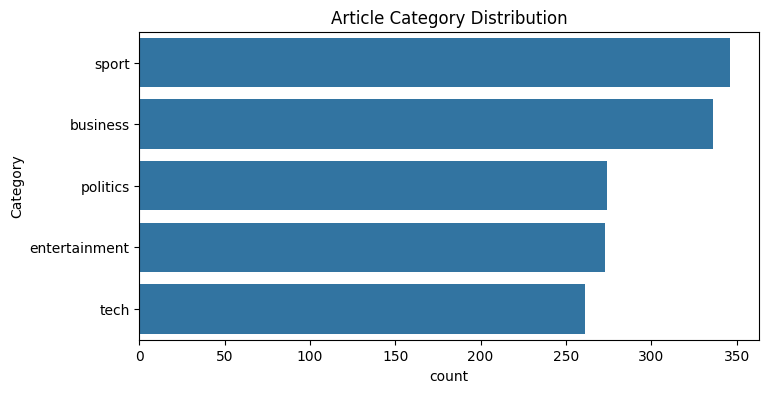

In [7]:
# Plot category distribution
plt.figure(figsize=(8,4))
sns.countplot(data=train_df, y='Category', order=train_df['Category'].value_counts().index)
plt.title("Article Category Distribution")
plt.show()

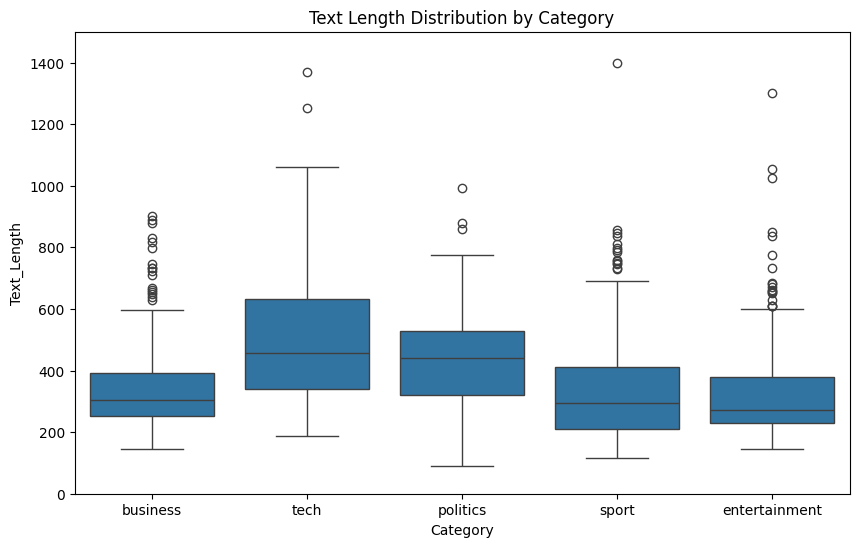

In [8]:
# Add text length column
train_df['Text_Length'] = train_df['Text'].apply(lambda x: len(x.split()))

# Plot text length distribution by category
plt.figure(figsize=(10,6))
sns.boxplot(data=train_df, x='Category', y='Text_Length')
plt.title("Text Length Distribution by Category")
plt.ylim(0, 1500)  # Adjust based on data
plt.show()

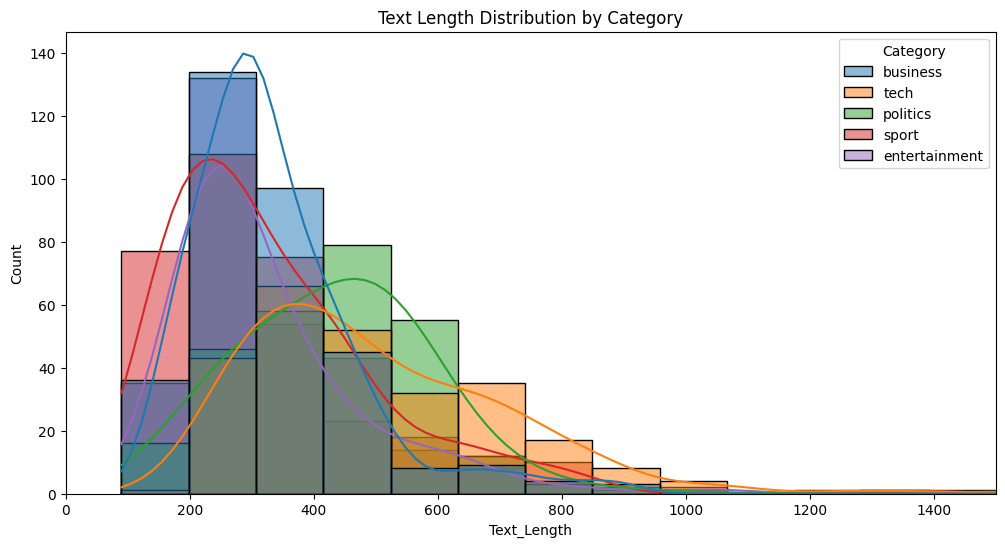

In [9]:
# Histogram to compare text length distributions across categories

plt.figure(figsize=(12,6))
sns.histplot(data=train_df, x='Text_Length', hue='Category', bins=30, kde=True)
plt.title("Text Length Distribution by Category")
plt.xlim(0, 1500)  # Remove extreme outliers
plt.show()

In [10]:
""" 
Text standardization:

Remove HTML tags (if any)

Lowercase all text

Handle contractions (e.g., "don’t" → "do not")
"""
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])
    return text.lower()

train_df['Cleaned_Text'] = train_df['Text'].apply(clean_text)

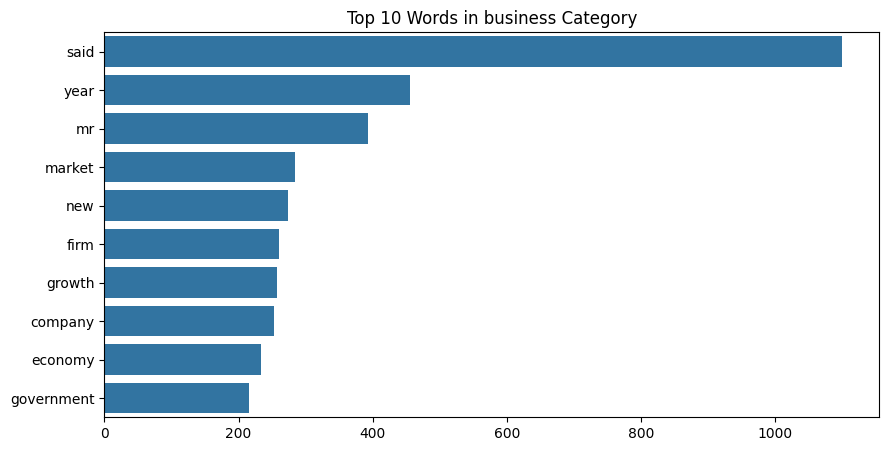

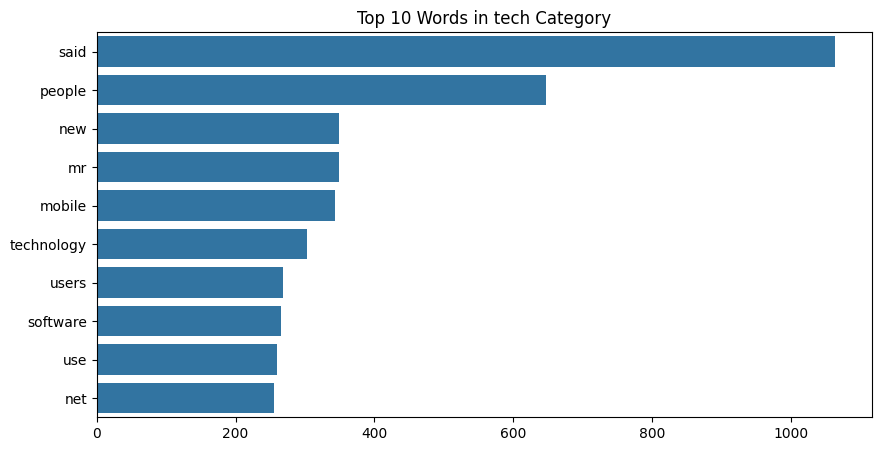

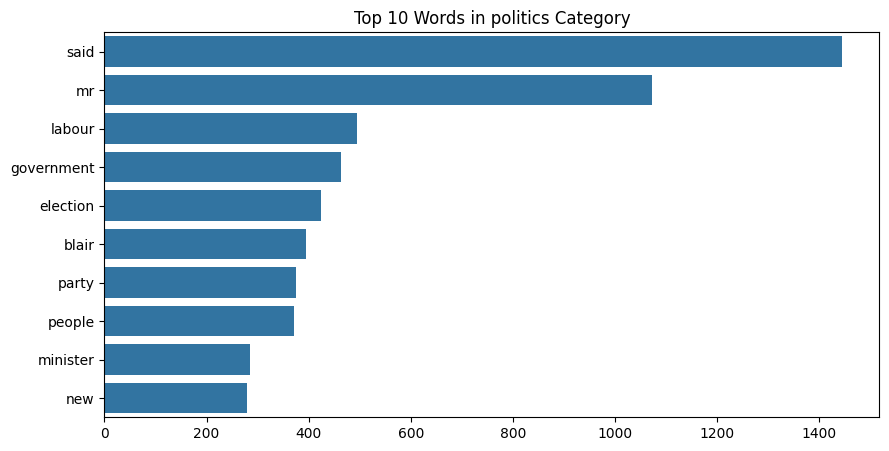

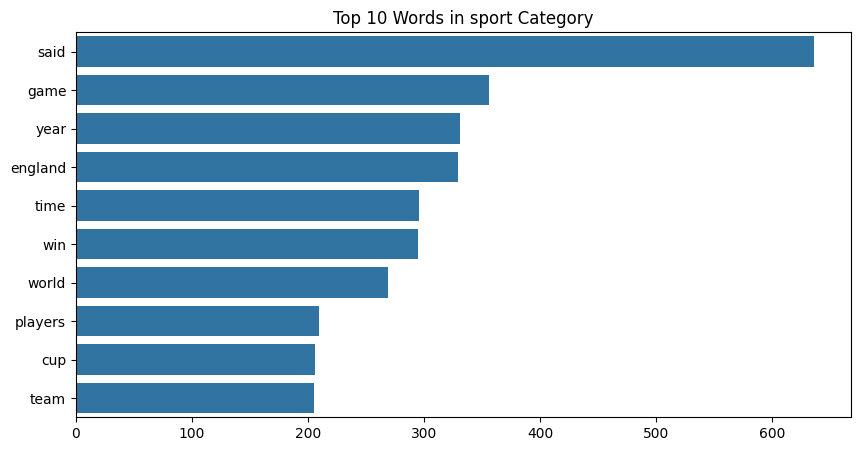

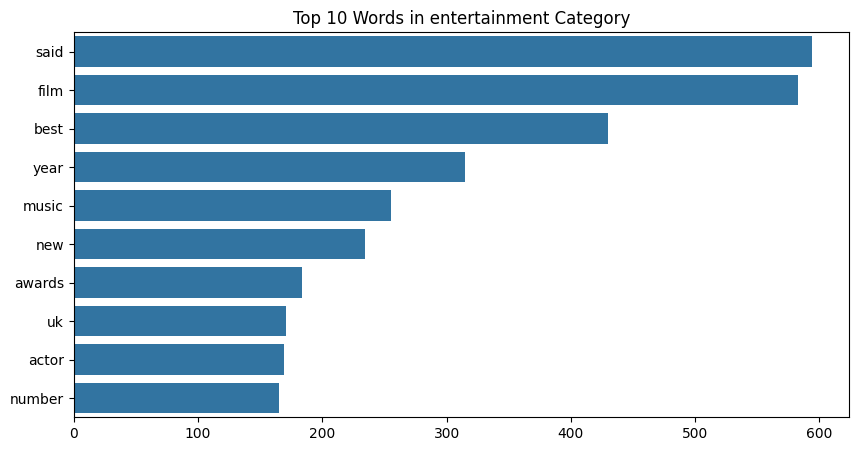

In [11]:
# Common words per category

for category in categories:
    text = train_df[train_df['Category'] == category]['Text']
    cv = CountVectorizer(stop_words='english', max_features=20)
    counts = cv.fit_transform(text)
    sum_words = counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10,5))
    sns.barplot(x=[w[1] for w in words_freq[:10]], y=[w[0] for w in words_freq[:10]])
    plt.title(f"Top 10 Words in {category} Category")
    plt.show()

In [12]:
# Check for missing values
print(train_df.isnull().sum())

ArticleId       0
Text            0
Category        0
Text_Length     0
Cleaned_Text    0
dtype: int64


Preprocessing Pipeline

Custom SpaCy Transformer

Lemmatize text

Remove stopwords, punctuation, and non-alphabetic tokens

Batch processing for efficiency

In [15]:
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, stop_words='english')),
    ('nmf', NMF(n_components=5, random_state=42)),  # 5 topics for 5 categories
    ('clf', LogisticRegression(max_iter=1000))
])

In [ ]:
# Fit on training data
pipeline.fit(X_train, y_train)

# Predict on train/test
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)